In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import *
from sklearn.impute import *
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import *
import numpy as np
from sklearn.svm import SVC

In [2]:
df = pd.read_csv("resultados_SVC_1.csv")
df.head(5)

,strategy,k,kernel,c,degree,f1,elapsed_time
0,most_frequent,18,rbf,6,3,0.462208,0.181970
1,median,118,rbf,5,5,0.491696,0.135952
2,median,93,rbf,18,9,0.498387,0.141248
3,mean,263,linear,15,15,0.532735,0.123264
4,mean,128,linear,15,17,0.532829,0.111586


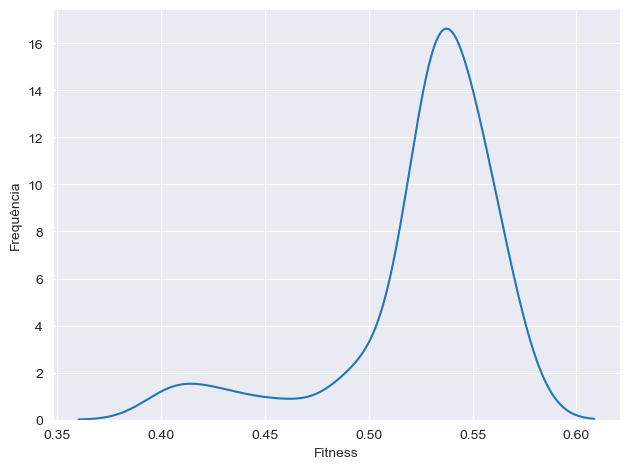

In [3]:
fig, ax = plt.subplots()
sns.kdeplot(df, x="f1", ax=ax)
ax.set_ylabel("Frequência")
ax.set_xlabel("Fitness")
fig.tight_layout()

<Axes: xlabel='elapsed_time', ylabel='Density'>

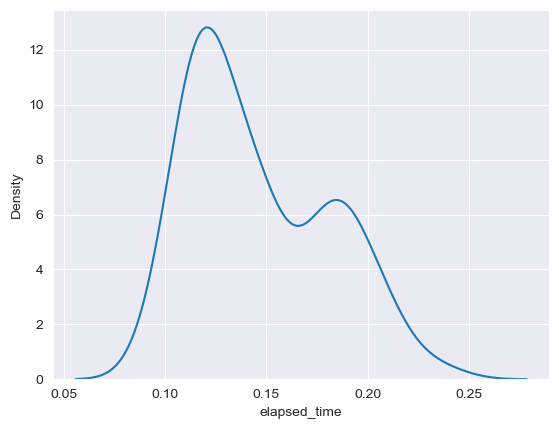

In [4]:
sns.kdeplot(df, x="elapsed_time")

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


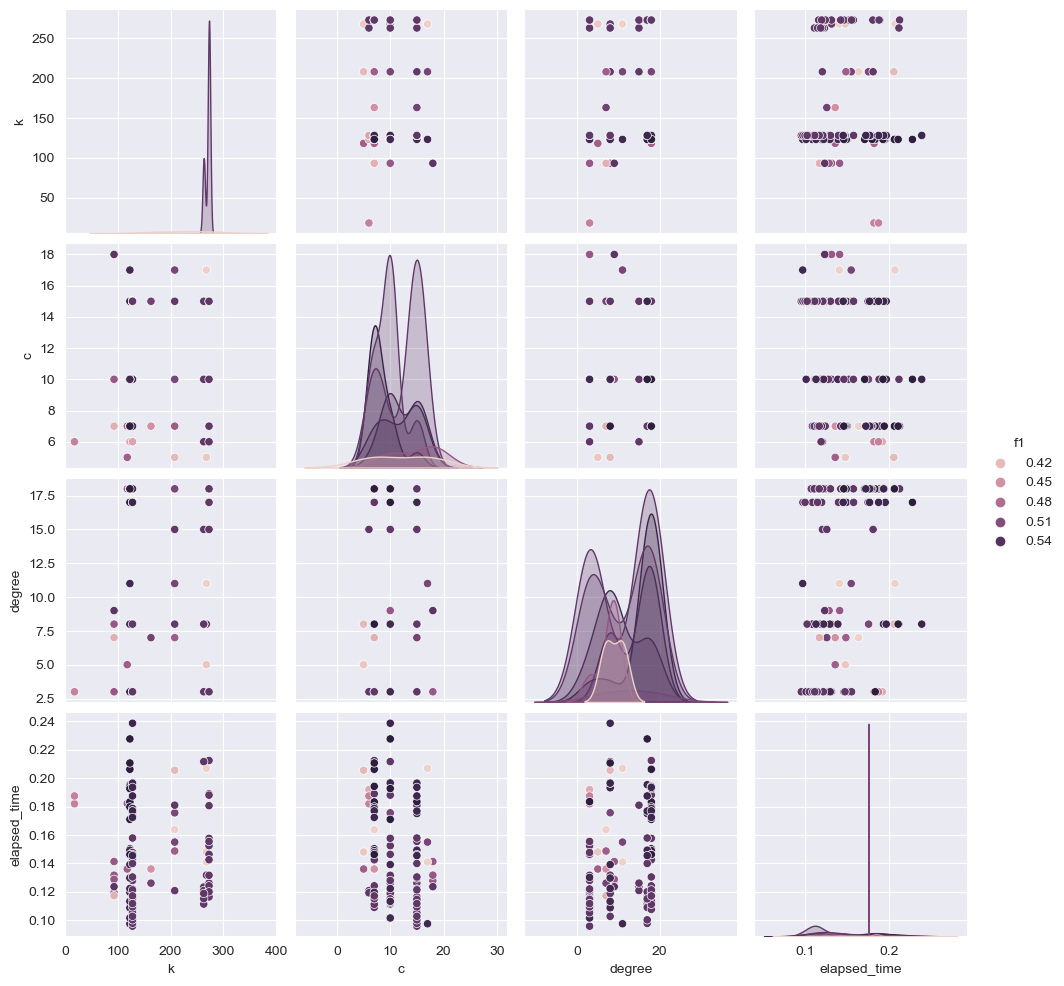

In [5]:
sns.pairplot(df, hue="f1")

In [6]:
X = df.to_numpy()[:, :-2]
y = df["f1"].astype(float)

df.head(5)

,strategy,k,kernel,c,degree,f1,elapsed_time
0,most_frequent,18,rbf,6,3,0.462208,0.181970
1,median,118,rbf,5,5,0.491696,0.135952
2,median,93,rbf,18,9,0.498387,0.141248
3,mean,263,linear,15,15,0.532735,0.123264
4,mean,128,linear,15,17,0.532829,0.111586


In [7]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X)
X_encoded = enc.transform(X).toarray()

X_encoded

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [8]:
#t-SNE
x_embedded = TSNE(n_components=2).fit_transform(X_encoded)

x_embedded[:10]

array([[-126.62195 ,  -13.752655],
       [ -64.31309 , -116.96296 ],
       [-100.024475, -116.34752 ],
       [ 108.76235 ,  -18.79698 ],
       [  60.8116  ,   69.65418 ],
       [ -85.44486 ,   44.18896 ],
       [-117.06698 ,  -64.61467 ],
       [ -22.095245,  -95.45091 ],
       [  65.62391 ,  -41.417297],
       [ -52.56226 ,  -57.58728 ]], dtype=float32)

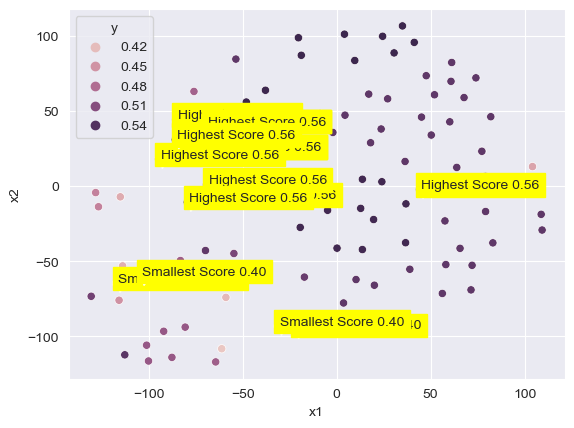

In [9]:
x_embedded_f1 = np.column_stack((x_embedded, df['f1']))
_df = pd.DataFrame(data=x_embedded_f1, columns=["x1", "x2", "y"])
_df.head(5)
ax = sns.scatterplot(data=_df, x="x1", y="x2", hue="y")

# plot highest fitness
coord = _df.loc[_df["y"] == _df["y"].max()]
for i, row in coord.iterrows():
    x, y = row["x1"], row["x2"]
    ax.annotate(f"Highest Score {row['y']:>.2f}", (x, y), (x + 1, y + 1),
                arrowprops={"width": 3, "headwidth": 7, "headlength": 6}, backgroundcolor="yellow")

# plot lowest fitness
coord = _df.loc[_df["y"] == _df["y"].min()]
for i, row in coord.iterrows():
    x, y = row["x1"], row["x2"]
    ax.annotate(f"Smallest Score {row['y']:>.2f}", (x, y), (x + 1, y + 1),
                arrowprops={"width": 3, "headwidth": 7, "headlength": 6}, backgroundcolor="yellow")

In [10]:
df.loc[df.f1 == df.f1.max()]

,strategy,k,kernel,c,degree,f1,elapsed_time
5,most_frequent,123,linear,7,18,0.564372,0.150222
50,most_frequent,123,linear,10,18,0.564372,0.170968
53,most_frequent,123,linear,15,3,0.564372,0.183477
61,most_frequent,123,linear,7,18,0.564372,0.148944
67,most_frequent,123,linear,7,18,0.564372,0.206466
69,most_frequent,123,linear,7,18,0.564372,0.194234
76,most_frequent,123,linear,7,18,0.564372,0.183244
77,most_frequent,123,linear,7,18,0.564372,0.206254
84,most_frequent,123,linear,10,18,0.564372,0.192668
88,most_frequent,123,linear,7,18,0.564372,0.179774


In [ ]:
RANDOM_STATE = 42

df_X = pd.read_csv("arrhythmia.csv", header=None).replace("?", np.nan)
data = df_X.to_numpy()
X, y = data[:, :-1], data[:, -1]
X = X.astype(float)
y = pd.Series(y).astype(float)

preprocess = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent"))])

pipeline = pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('scaler', StandardScaler()),
    ('feature-selection', SelectKBest(k=123)),
    ('svc', SVC(
        kernel="linear",
        C=7,
        degree=18,
        probability=True,
        random_state=RANDOM_STATE))])

pipeline.fit(X, y)
X = preprocess.fit_transform(X, y)
class_ = pipeline.classes_
y_pred = pipeline.predict(X)

explainer = LimeTabularExplainer(X,
                                 feature_names=df_X.columns[:-1],
                                 class_names=class_)

for i, (y, yp) in enumerate(zip(y, y_pred)):
    if y == yp:
        print(f"classe real: {y}, predição: {yp}")
        exp = explainer.explain_instance(X[i], pipeline.predict_proba)
        exp.show_in_notebook(show_table=True, show_all=False)